## <span style="color:#0b486b">Part 2: Deep Neural Networks (DNN) </span>
<div style="text-align: right"><span style="color:red">[Total marks for this part: 30 points]<span></div>

The first part of this assignment is for you to demonstrate your basis knowledge in deep learning that you have acquired from the lectures and tutorials materials. Most of the contents in this assignment are drawn from **the tutorials covered from weeks 1 to 5**. Going through these materials before attempting this assignment is highly recommended.

You are going to work with the **EMNIST** dataset for *image recognition task*. This dataset can be installed with the command <kbd>pip install emnist</kbd>. It has the exact same format as MNIST (grayscale images of 28 × 28 pixels), but the images represent handwritten letters rather than handwritten digits, so the problem is more challenging than MNIST.

### <span style="color:#0b486b">Question 2.1: Load the EMNIST datasets and process data</span> 


<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

We first use functions in the package **emnist**, namely <kbd>extract_training_samples</kbd> and <kbd>extract_test_samples</kbd>, to load the training and testing sets. We also want to encode labels using an ordinal encoding scheme.

In [1]:
import numpy as np
from emnist import extract_training_samples, extract_test_samples
from sklearn.preprocessing import LabelEncoder

In [2]:

X_train_raw, y_train_raw = extract_training_samples('letters')
X_test_raw, y_test_raw =  extract_test_samples('letters')
print(X_train_raw.shape, y_train_raw.shape, X_test_raw.shape, y_test_raw.shape)

(124800, 28, 28) (124800,) (20800, 28, 28) (20800,)


In [3]:
le = LabelEncoder()
y_train_full = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

class_ids = np.unique(y_train_full)
n_classes = len(class_ids)
print(class_ids)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


The shape of training and testing data are $(num\_train, 28, 28)$ and $(num\_test, 28, 28)$, where $num\_train$ and $num\_test$ are number of training and testing images respectively. We next convert them to arrays of vectors which have shape $(num\_train, 784)$ and $(num\_test, 784)$.

In [4]:
num_train = X_train_raw.shape[0]
num_test = X_test_raw.shape[0]
X_train_full = X_train_raw.reshape(num_train,-1)/255.0
X_test = X_test_raw.reshape(num_test, -1)/255.0
print(X_train_full.shape, y_train_full.shape)
print(X_test.shape, y_test.shape)

(124800, 784) (124800,)
(20800, 784) (20800,)


### <span style="color:#0b486b">Question 2.2: Split data into training, validation, and testing datasets</span>

<div style="text-align: right"> <span style="color:red">[2 points]</span> </div>

You need to write the code to address the following requirements:
- Use $10 \%$ of `X_train_full`, `y_train_full` for validation and the rest of `X_train_full`, `y_train_full` for training. This splits `X_train_full` and `y_train_full` into `X_train`, `y_train` ($90 \%$) and `X_val`, `y_val` ($10 \%$).
- Finally, scale the pixels of `X_train`, `X_val`, and `X_test` to $[0,1]$) (i.e., $X = X/255.0$).

You have now the separate training, validation, and testing sets for training your model.



In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=33) 
X_train, X_val, X_test = X_train/255.0, X_val/255.0, X_test/255.0

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)   
print(X_test.shape, y_test.shape)

print(X_train.min(), X_train.max(), X_val.min(), X_val.max(), X_test.min(), X_test.max())

(112320, 784) (112320,)
(12480, 784) (12480,)
(20800, 784) (20800,)
0.0 0.00392156862745098 0.0 0.00392156862745098 0.0 0.00392156862745098


### <span style="color:#0b486b">Question 2.3: Visualize some images in the training set with labels</span>

<div style="text-align: right"> <span style="color:red">[5 points]</span> </div>

You are required to write the code to **randomly** show $36$ images in X_train_full_img (which is an array of images) with labels as in the following figure.

<img src="Figures/emnist_grid.png" width="450" align="center"/>

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# YOU ARE REQUIRED TO INSERT YOUR CODES IN THIS CELL
# You can add more cells if necessary

import math
def visualize_data(images, categories, images_per_row = 6):
    class_names = ['A', 'B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
   
    n_rows = 6
    fig = plt.figure(figsize=(1.5*images_per_row, 1.5*n_rows))
    fig.patch.set_facecolor('white')
    
    # return a list of randomly selected image
    image_index = np.random.randint(0, len(images), 6 * 6)
    images_selected = images[image_index]
    n_images = len(images_selected)

    # take labels for these images only
    categories_selected = []
    for i in image_index:
        categories_selected.append(categories[i])

    
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        pixels = images_selected[i].reshape((28, 28))
        plt.imshow(pixels,cmap=plt.cm.binary)
        class_index = categories_selected[i]
        plt.xlabel(class_names[class_index])
    plt.show()


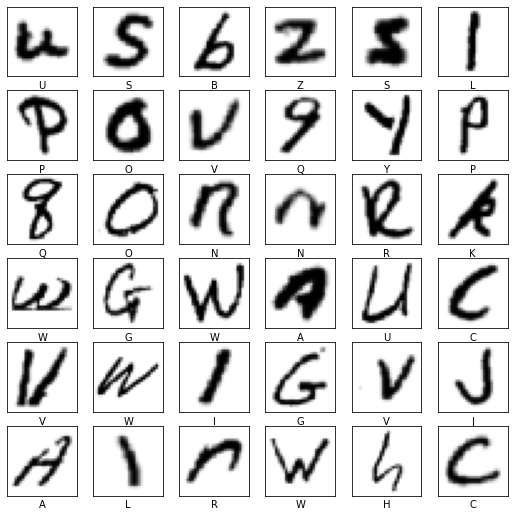

In [8]:
visualize_data(X_train, y_train)

### <span style="color:#0b486b">Question 2.4: Write code for the feed-forward neural net using TF 2.x</span>

<div style="text-align: right"> <span style="color:red">[5 points]</span> </div>

We now develop a feed-forward neural network with the architecture $784 \rightarrow 20(ReLU) \rightarrow 40(ReLU) \rightarrow 26(softmax)$. You can choose your own way to implement your network and an optimizer of interest. You should train model in $20$ epochs and evaluate the trained model on the test set.

In [9]:
import tensorflow as tf
random_seed = 3181
tf.random.set_seed(random_seed)

In [10]:
# YOU ARE REQUIRED TO INSERT YOUR CODES IN THIS CELL
# You can add more cells if necessary
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential

dnn_model = Sequential()
dnn_model.add(Dense(units=20,  input_shape=(784,), activation='relu'))
dnn_model.add(Dense(units=40, activation='relu'))
dnn_model.add(Dense(units=n_classes, activation='softmax'))

**build the model**

In [11]:
dnn_model.build()
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                15700     
                                                                 
 dense_1 (Dense)             (None, 40)                840       
                                                                 
 dense_2 (Dense)             (None, 26)                1066      
                                                                 
Total params: 17,606
Trainable params: 17,606
Non-trainable params: 0
_________________________________________________________________


**excution**

In [12]:
dnn_model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

In [14]:
# Call the fit method, passing the tensorboard_callback 
history = dnn_model.fit(x=X_train, y=y_train, batch_size=32, 
                        epochs=20, 
                        validation_data=(X_val, y_val))

Epoch 1/20
3510/3510 [==============================] - 5s 1ms/step - loss: 2.2443 - accuracy: 0.3221 - val_loss: 1.8868 - val_accuracy: 0.4179
Epoch 2/20
3510/3510 [==============================] - 4s 1ms/step - loss: 1.7034 - accuracy: 0.4774 - val_loss: 1.5992 - val_accuracy: 0.5119
Epoch 3/20
3510/3510 [==============================] - 4s 1ms/step - loss: 1.4899 - accuracy: 0.5462 - val_loss: 1.4319 - val_accuracy: 0.5679
Epoch 4/20
3510/3510 [==============================] - 5s 1ms/step - loss: 1.3537 - accuracy: 0.5920 - val_loss: 1.3300 - val_accuracy: 0.6022
Epoch 5/20
3510/3510 [==============================] - 5s 1ms/step - loss: 1.2608 - accuracy: 0.6203 - val_loss: 1.2470 - val_accuracy: 0.6254
Epoch 6/20
3510/3510 [==============================] - 5s 1ms/step - loss: 1.1917 - accuracy: 0.6421 - val_loss: 1.1914 - val_accuracy: 0.6387
Epoch 7/20
3510/3510 [==============================] - 5s 1ms/step - loss: 1.1374 - accuracy: 0.6571 - val_loss: 1.1377 - val_accuracy:

Evaluate on test set

In [15]:
dnn_model.evaluate(X_test, y_test)

650/650 [==============================] - 1s 997us/step - loss: 0.8240 - accuracy: 0.7558


[0.8239888548851013, 0.7558172941207886]

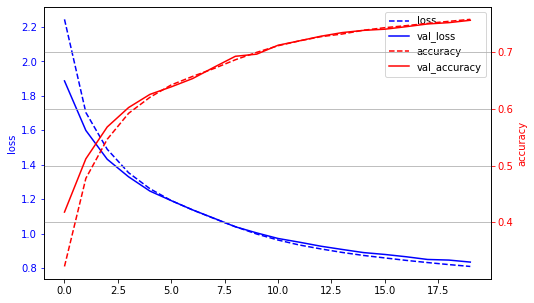

In [16]:
import pandas as pd
import matplotlib.pyplot as plt


his = history.history 
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ln1 = ax.plot(his['loss'], 'b--',label='loss')
ln2 = ax.plot(his['val_loss'], 'b-',label='val_loss')
ax.set_ylabel('loss', color='blue')
ax.tick_params(axis='y', colors="blue")

ax2 = ax.twinx()
ln3 = ax2.plot(his['accuracy'], 'r--',label='accuracy')
ln4 = ax2.plot(his['val_accuracy'], 'r-',label='val_accuracy')
ax2.set_ylabel('accuracy', color='red')
ax2.tick_params(axis='y', colors="red")


lns = ln1 + ln2 + ln3 + ln4 
labels = [l.get_label() for l in lns]
ax.legend(lns, labels)
plt.grid(True)
plt.show()

#### Evaluation on DNN model

The accuracy for this model is 0.7558 and loss is 0.824. Also based on the graph above, we can see that it is learning quite well and generalised where the validation loss and loss are close to each other and for accuracy and validation accuracy are also close to each other.

### <span style="color:#0b486b">Question 2.5: Tuning hyper-parameters with grid search</span>
<div style="text-align: right"> <span style="color:red">[6 points]</span> </div>

Assume that you need to tune the number of neurons on the first and second hidden layers $n_1 \in \{20, 40\}$, $n_2 \in \{20, 40\}$  and the used activation function  $act \in \{sigmoid, tanh, relu\}$. The network has the architecture pattern $784 \rightarrow n_1 (act) \rightarrow n_2(act) \rightarrow 26(softmax)$ where $n_1, n_2$, and $act$ are in their grides. Write the code to tune the hyper-parameters $n_1, n_2$, and $act$. Note that you can freely choose the optimizer and learning rate of interest for this task.

In [17]:
# YOU ARE REQUIRED TO INSERT YOUR CODES IN THIS CELL
# You can add more cells if necessary
class NewDNN(tf.keras.Model):
    def __init__(self, n1, n2, act, num_classes= 26):
        super(NewDNN, self).__init__()
        self.num_classes = num_classes
        self.dense1 = tf.keras.layers.Dense(n1, activation=act)
        self.dense2 = tf.keras.layers.Dense(n2, activation= act)
        self.dense3 = tf.keras.layers.Dense(self.num_classes, activation= 'softmax')
    
    def call(self, inputs):
        h = self.dense1(inputs)
        h = self.dense2(h)
        h = self.dense3(h)
        return h


In [18]:
#lst_opts = [tf.keras.optimizers.Adam(), tf.keras.optimizers.RMSprop(), tf.keras.optimizers.SGD(momentum=0.2)]
#lst_learning_rates = [0.1, 0.01, 0.001]

act = ['sigmoid','tanh','relu']
n1 = [20,40]
n2 = [20,40]

best_acc= - np.inf
best_history = None
opt = tf.keras.optimizers.SGD(learning_rate=0.001)

for i in n1:
    for j in n2:
        for a in act:
            dnn = NewDNN(i, j, a, num_classes=26)
            dnn.build(input_shape = (None, 784))
            opt.learning_rate = 0.01
            dnn.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            print("Training with optimizer = {}, activation function = {}, n1 = {}, n2 = {}".format(opt.get_config()['name'], a, i, j))
            history = dnn.fit(X_train, y_train, batch_size=32, epochs=10, verbose=0)
            valid_loss, valid_acc = dnn.evaluate(X_val, y_val)
            print('\tvalid acc = {}, valid loss = {}'.format(valid_acc, valid_loss))
            if(valid_acc > best_acc):
                best_acc = valid_acc
                best_model = dnn
                best_n1 = i
                best_n2 = j
                best_act = a
                best_opt = opt
                best_lr = 0.01
                best_history = history

Training with optimizer = SGD, activation function = sigmoid, n1 = 20, n2 = 20
390/390 [==============================] - 1s 1ms/step - loss: 1.4403 - accuracy: 0.5606
	valid acc = 0.5605769157409668, valid loss = 1.4403090476989746
Training with optimizer = SGD, activation function = tanh, n1 = 20, n2 = 20
390/390 [==============================] - 1s 1ms/step - loss: 0.9652 - accuracy: 0.7196
	valid acc = 0.7196314334869385, valid loss = 0.965171754360199
Training with optimizer = SGD, activation function = relu, n1 = 20, n2 = 20
390/390 [==============================] - 1s 1ms/step - loss: 1.1738 - accuracy: 0.6507
	valid acc = 0.6507211327552795, valid loss = 1.1737604141235352
Training with optimizer = SGD, activation function = sigmoid, n1 = 20, n2 = 40
390/390 [==============================] - 1s 1ms/step - loss: 1.4040 - accuracy: 0.5706
	valid acc = 0.5705929398536682, valid loss = 1.4040038585662842
Training with optimizer = SGD, activation function = tanh, n1 = 20, n2 = 40

In [20]:
print('\nThe best model is with optimizer = {}, learning rate = {}, activation function = {}, n1 = {}, n2 = {}'.format(best_opt.get_config()['name'], best_lr, best_act, best_n1, best_n2))



The best model is with optimizer = SGD, learning rate = 0.01, activation function = tanh, n1 = 40, n2 = 40


### <span style="color:#0b486b">Question 2.6: Experimenting with the **label smoothing** technique</span>
<div style="text-align: right"> <span style="color:red">[8 points]</span> </div>

Implement the label smoothing technique (i.e., [link for main paper](https://papers.nips.cc/paper/2019/file/f1748d6b0fd9d439f71450117eba2725-Paper.pdf) from Goeff Hinton) by yourself. Note that you cannot use the built-in label-smoothing loss function in TF2.x. Try the label smoothing technique with $\alpha =0.1, 0.15, 0.2$ and report the performances. You need to examine the label smoothing technique with the best architecture obtained in **Question 2.5**.

In [147]:
# YOU ARE REQUIRED TO INSERT YOUR CODES IN THIS CELL
# You can add more cells if necessary
class smooth_CE_loss(tf.keras.losses.Loss):
    def __init__(self, alpha, eps=1E-10, num_classes= 10):
        super(smooth_CE_loss, self).__init__()
        self.eps = eps
        self.num_classes = num_classes
        self.alpha = alpha
        
    def call(self, y_true, y_pred):
        #using 1 hot encoding
        cast_y_true = tf.cast(y_true, dtype=tf.float32)
        smoothed_label = ((1 - self.alpha) * cast_y_true) + (self.alpha / self.num_classes)

        #use tf.print(y_true_1_hot) here in case you want to print out values
        loss = -tf.math.multiply(smoothed_label, tf.math.log(y_pred + self.eps))
        loss = tf.reduce_mean(loss)
        return loss

In [19]:
# YOU ARE REQUIRED TO INSERT YOUR CODES IN THIS CELL
# You can add more cells if necessary
        
def smooth_label(alpha, labels, n_class):
    #using 1 hot encoding
    cast_y_labels = tf.cast(labels, dtype=tf.float32)
    smoothed_labels = ((1 - alpha) * cast_y_labels) + (alpha / n_classes)

    return smoothed_labels

try with  $\alpha =0.1, 0.15, 0.2$ <br>
<br>
Best model found from question 2.5 with using n1 =40,n2 = 40, activation fucntion = tanh, learning rate=0.01, optimiser = adam()

In [22]:
alpha = [0.1,0.15,0.2]

best_acc= - np.inf
best_history = None
#opt = tf.keras.optimizers.SGD(learning_rate=0.001)

for a in alpha:
    dnn2 = NewDNN(40, 40, "tanh", num_classes=26)
    dnn2.build(input_shape = (None, 784))
    opt.learning_rate = 0.01
    dnn2.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print("Training with optimizer = {}, alpha = {}, n1 = {}, n2 = {}".format(opt.get_config()['name'], a, i, j))
    history = dnn2.fit(X_train, smooth_label(a,y_train,26), batch_size=32, epochs=10, verbose=0)
    valid_loss, valid_acc = dnn2.evaluate(X_val, y_val)
    print('\tvalid acc = {}, valid loss = {}'.format(valid_acc, valid_loss))
    if(valid_acc > best_acc):
        best_acc2 = valid_acc
        best_model2 = dnn2
        best_alpha = a
        best_opt2 = tf.keras.optimizers.Adam()
        best_lr2 = 0.01
        best_history2 = history

Training with optimizer = SGD, alpha = 0.1, n1 = 40, n2 = 40
390/390 [==============================] - 1s 1ms/step - loss: 9.9714 - accuracy: 0.0341
	valid acc = 0.03413461521267891, valid loss = 9.971376419067383
Training with optimizer = SGD, alpha = 0.15, n1 = 40, n2 = 40
390/390 [==============================] - 1s 1ms/step - loss: 11.0811 - accuracy: 0.0264
	valid acc = 0.026362178847193718, valid loss = 11.081079483032227
Training with optimizer = SGD, alpha = 0.2, n1 = 40, n2 = 40
390/390 [==============================] - 1s 1ms/step - loss: 11.3036 - accuracy: 0.0362
	valid acc = 0.03621795028448105, valid loss = 11.303604125976562
